# The original Jupyter notebook by Bastings (https://bastings.github.io/annotated_encoder_decoder/) entitled Annotated Encoder-Decoder with Attention  was modified for the SIGMORPHON 2016 task1 (Morphological Reinflections) by Michael Grodecki.

The algorithm is based on the the attention-based neural machine translation paper ["Neural Machine Translation by Jointly Learning to Align and Translate"](https://arxiv.org/abs/1409.0473) by Bahdanau et al. (2015) and the paper by Kann and Schutze (2016) describing the SIGMORPHON 2016 winning system ["MED: The LMU System for the SIGMORPHON 2016 Shared Task on Morphological Reinflection"] (https://aclanthology.org/W16-2010.pdf).


# Model Architecture

We will model the probability $p(Y\mid X)$ of a target sequence $Y=(y_1, \dots, y_{N})$ given a source sequence $X=(x_1, \dots, x_M)$ directly with a neural network: an Encoder-Decoder.

#### Encoder 

The encoder reads in the source sentence (*at the bottom of the figure*) and produces a sequence of hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$, one for each source word. These states should capture the meaning of a word in its context of the given sentence.

We will use a bi-directional recurrent neural network (Bi-RNN) as the encoder; a Bi-GRU in particular.

First of all we **embed** the source words. 
We simply look up the **word embedding** for each word in a (randomly initialized) lookup table.
We will denote the word embedding for word $i$ in a given sentence with $\mathbf{x}_i$.
By embedding words, our model may exploit the fact that certain words (e.g. *cat* and *dog*) are semantically similar, and can be processed in a similar way.

Now, how do we get hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$? A forward GRU reads the source sentence left-to-right, while a backward GRU reads it right-to-left.
Each of them follows a simple recursive formula: 
$$\mathbf{h}_j = \text{GRU}( \mathbf{x}_j , \mathbf{h}_{j - 1} )$$
i.e. we obtain the next state from the previous state and the current input word embedding.

The hidden state of the forward GRU at time step $j$ will know what words **precede** the word at that time step, but it doesn't know what words will follow. In contrast, the backward GRU will only know what words **follow** the word at time step $j$. By **concatenating** those two hidden states (*shown in blue in the figure*), we get $\mathbf{h}_j$, which captures word $j$ in its full sentence context.


#### Decoder 

The decoder (*at the top of the figure*) is a GRU with hidden state $\mathbf{s_i}$. It follows a similar formula to the encoder, but takes one extra input $\mathbf{c}_{i}$ (*shown in yellow*).

$$\mathbf{s}_{i} = f( \mathbf{s}_{i - 1}, \mathbf{y}_{i - 1}, \mathbf{c}_i )$$

Here, $\mathbf{y}_{i - 1}$ is the previously generated target word (*not shown*).

At each time step, an **attention mechanism** dynamically selects that part of the source sentence that is most relevant for predicting the current target word. It does so by comparing the last decoder state with each source hidden state. The result is a context vector $\mathbf{c_i}$ (*shown in yellow*).
Later the attention mechanism is explained in more detail.

After computing the decoder state $\mathbf{s}_i$, a non-linear function $g$ (which applies a [softmax](https://en.wikipedia.org/wiki/Softmax_function)) gives us the probability of the target word $y_i$ for this time step:

$$ p(y_i \mid y_{<i}, x_1^M) = g(\mathbf{s}_i, \mathbf{c}_i, \mathbf{y}_{i - 1})$$

Because $g$ applies a softmax, it provides a vector the size of the output vocabulary that sums to 1.0: it is a distribution over all target words. During test time, we would select the word with the highest probability for our translation.

Now, for optimization, a [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) is used to maximize the probability of selecting the correct word at this time step. All parameters (including word embeddings) are then updated to maximize this probability.




In [ ]:
!pip install torch numpy matplotlib sacrebleu

In [ ]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: True
cuda:0


## EncoderDecoder class

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

To keep things easy we also keep the `Generator` class the same. 
It simply projects the pre-output layer ($x$ in the `forward` function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [ ]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder

Our encoder is a bi-directional GRU. 

Because we want to process multiple sentences at the same time for speed reasons (it is more effcient on GPU), we need to support **mini-batches**. Sentences in a mini-batch may have different lengths, which means that the RNN needs to unroll further for certain sentences while it might already have finished for others:

```
Example: mini-batch with 3 source sentences of different lengths (7, 5, and 3).
End-of-sequence is marked with a "3" here, and padding positions with "1".

+---------------+
| 4 5 9 8 7 8 3 |
+---------------+
| 5 4 8 7 3 1 1 |
+---------------+
| 5 8 3 1 1 1 1 |
+---------------+
```
You can see that, when computing hidden states for this mini-batch, for sentence #2 and #3 we will need to stop updating the hidden state after we have encountered "3". We don't want to incorporate the padding values (1s).

Luckily, PyTorch has convenient helper functions called `pack_padded_sequence` and `pad_packed_sequence`.
These functions take care of masking and padding, so that the resulting word representations are simply zeros after a sentence stops.

The code below reads in a source sentence (a sequence of word embeddings) and produces the hidden states.
It also returns a final vector, a summary of the complete sentence, by concatenating the first and the last hidden states (they have both seen the whole sentence, each in a different direction). We will use the final vector to initialize the decoder.

In [ ]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

### Decoder

The decoder is a conditional GRU. Rather than starting with an empty state like the encoder, its initial hidden state results from a projection of the encoder final vector. 

#### Training
In `forward` you can find a for-loop that computes the decoder hidden states one time step at a time. 
Note that, during training, we know exactly what the target words should be! (They are in `trg_embed`.) This means that we are not even checking here what the prediction is! We simply feed the correct previous target word embedding to the GRU at each time step. This is called teacher forcing.

The `forward` function returns all decoder hidden states and pre-output vectors. Elsewhere these are used to compute the loss, after which the parameters are updated.

#### Prediction
For prediction time, for forward function is only used for a single time step. After predicting a word from the returned pre-output vector, we can call it again, supplying it the word embedding of the previously predicted word and the last state.

In [ ]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))            


### Attention                                                                                                                                                                               

At every time step, the decoder has access to *all* source word representations $\mathbf{h}_1, \dots, \mathbf{h}_M$. 
An attention mechanism allows the model to focus on the currently most relevant part of the source sentence.
The state of the decoder is represented by GRU hidden state $\mathbf{s}_i$.
So if we want to know which source word representation(s) $\mathbf{h}_j$ are most relevant, we will need to define a function that takes those two things as input.

Here we use the MLP-based, additive attention that was used in Bahdanau et al. (2015).

We apply an MLP with tanh-activation to both the current decoder state $\bf s_i$ (the *query*) and each encoder state $\bf h_j$ (the *key*), and then project this to a single value (i.e. a scalar) to get the *attention energy* $e_{ij}$. 

Once all energies are computed, they are normalized by a softmax so that they sum to one: 

$$ \alpha_{ij} = \text{softmax}(\mathbf{e}_i)[j] $$

$$\sum_j \alpha_{ij} = 1.0$$ 

The context vector for time step $i$ is then a weighted sum of the encoder hidden states (the *values*):
$$\mathbf{c}_i = \sum_j \alpha_{ij} \mathbf{h}_j$$

In [ ]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

## Full Model

Here we define a function from hyperparameters to a full model. 

In [ ]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

# Training


## Batches and Masking

In [ ]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        #print("len(src) = ", len(src))
        #print(src)
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()
                

## Training Loop
The code below trains the model for 1 epoch (=1 pass through the training data).

In [ ]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

## Training Data and Batching

We will use torch text for batching.

## Optimizer

We will use the [Adam optimizer](https://arxiv.org/abs/1412.6980) with default settings ($\beta_1=0.9$, $\beta_2=0.999$ and $\epsilon=10^{-8}$).

We will use $0.0003$ as the learning rate here. You will have to tune that.

## Loss Computation

In [ ]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

### Printing examples

To monitor progress during training, we will translate a few examples.

We use greedy decoding for simplicity; that is, at each time step, starting at the first token, we choose the one with that maximum probability, and we never revisit that choice. 

In [ ]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [ ]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi['<eos>']
        trg_sos_index = trg_vocab.stoi['<bos>']
        trg_eos_index = trg_vocab.stoi['<eos>']
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break

# Morphological inflection dataset


In [ ]:
#pip install git+git://github.com/pytorch/text spacy 
!pip uninstall torchtext
!pip install torchtext==0.4.0
!pip install spacy
!python -m spacy download en
!python -m spacy download de

In [ ]:
import torchtext
print(torchtext.__version__)
from torchtext import data

def read_data(example_file, datafields, lem_col=0, word_col=2, feat_col=1, feature_sep=','):
  with open(example_file, encoding='utf-8') as f:
    examples = []
    for line in f:
        line = line.strip()

        l_w_f = line.split('\t')
        lemma = l_w_f[lem_col]
        word = l_w_f[word_col]
        features = l_w_f[feat_col].split(feature_sep)
            
        src = list(lemma) + ['<features>'] + features
        trg = list(word)
            
        examples.append(torchtext.data.Example.fromlist([src, trg], datafields))
  return torchtext.data.Dataset(examples, datafields)

0.4.0


In [ ]:
SRC = torchtext.data.Field(init_token='<bos>', eos_token='<eos>',
                               sequential=True, batch_first=True, include_lengths=True, pad_token='<pad>')
TRG = torchtext.data.Field(init_token='<bos>', eos_token='<eos>',
                                sequential=True, batch_first=True, include_lengths=True, unk_token=None, pad_token='<pad>')


datafields = [('src', SRC), ('trg', TRG)]


In [ ]:
from google.colab import drive
drive.mount('/data', force_remount=True)

Mounted at /data


In [90]:
#load train dataset
traindataset = read_data("/data/My Drive/data/russian-task1-train", datafields)
print(len(traindataset))

print("First 5 training examples:")
for i in range(0, 5):
  print("src:", " ".join(vars(traindataset[i])['src']))
  print("trg:", " ".join(vars(traindataset[i])['trg']))

#load dev dataset
devdataset = read_data("/data/My Drive/data/russian-task1-dev", datafields)
print(len(devdataset))

print("First 5 dev examples:")
for i in range(0, 5):
  print("src:", " ".join(vars(devdataset[i])['src']))
  print("trg:", " ".join(vars(devdataset[i])['trg']))

#build vocabulary
SRC.build_vocab(traindataset.src)
TRG.build_vocab(traindataset.trg)

print("Length of in_char vocabulary:", len(SRC.vocab))
print("Length of out_char vocabulary:", len(TRG.vocab))

#create iterator
training_iter = data.BucketIterator(traindataset, batch_size=64, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)

validation_iter = data.Iterator(devdataset, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)

PAD_TOKEN = "<pad>"
PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]
print("PAD_INDEX: ",PAD_INDEX)



12390
First 5 training examples:
src: а а к <features> pos=N case=GEN num=SG
trg: а а к а
src: а а м <features> pos=N case=INS num=PL
trg: а а м а м и
src: а а р о н о в е ц <features> pos=N case=GEN num=PL
trg: а а р о н о в ц е в
src: а б а а с <features> pos=N case=INS num=PL
trg: а б а а с а м и
src: а б а д а н е ц <features> pos=N case=DAT num=PL
trg: а б а д а н ц а м
1591
First 5 dev examples:
src: а а р о н о в е ц <features> pos=N case=ESS num=SG
trg: а а р о н о в ц е
src: а б о н е м е н т н ы й <features> pos=ADJ case=GEN gen=MASC num=SG
trg: а б о н е м е н т н о г о
src: а б с е н т и з м <features> pos=N case=DAT num=PL
trg: а б с е н т и з м а м
src: а б с о л ю т и з м <features> pos=N case=ESS num=SG
trg: а б с о л ю т и з м е
src: а б с о л ю т и с т <features> pos=N case=GEN num=SG
trg: а б с о л ю т и с т а
Length of in_char vocabulary: 69
Length of out_char vocabulary: 36
PAD_INDEX:  0


In [ ]:
class Batch2:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        #print("len(src) = ", len(src))
        #print(src.shape)
        #src_lengths = [1]*64
        src, src_lengths = src

        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()

def rebatch2(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch2(batch.src, batch.trg, pad_idx)                

In [ ]:
def train2(model, num_epochs=10, lr=0.0003, print_every=100):
        
    if USE_CUDA:
        model.cuda()
        print("using CUDA")

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch2(PAD_INDEX, b) for b in training_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch2(PAD_INDEX, x) for x in validation_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch2(PAD_INDEX, b) for b in validation_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities

In [ ]:
print(torch.__version__)

1.6.0


In [ ]:
!pip install torch==1.6.0 torchvision==0.7.0

## Train for 20 epochs

In [110]:
#train
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train2(model, num_epochs=20, lr=0.0003)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


using CUDA
Epoch 0
Epoch Step: 100 Loss: 12.649820 Tokens per Sec: 16472.511022

Example #1
Src :  <bos> а а р о н о в е ц <features> pos=N case=ESS num=SG
Trg :  а а р о н о в ц е
Pred:  а а р о н о в е

Example #2
Src :  <bos> а б о н е м е н т н ы й <features> pos=ADJ case=GEN gen=MASC num=SG
Trg :  а б о н е м е н т н о г о
Pred:  а б о н е м е н т н о й

Example #3
Src :  <bos> а б с е н т и з м <features> pos=N case=DAT num=PL
Trg :  а б с е н т и з м а м
Pred:  а б с е н т и з м у м

Validation perplexity: 1.820628
Epoch 1
Epoch Step: 100 Loss: 3.437076 Tokens per Sec: 17471.879454

Example #1
Src :  <bos> а а р о н о в е ц <features> pos=N case=ESS num=SG
Trg :  а а р о н о в ц е
Pred:  а а р о н о в е ц е

Example #2
Src :  <bos> а б о н е м е н т н ы й <features> pos=ADJ case=GEN gen=MASC num=SG
Trg :  а б о н е м е н т н о г о
Pred:  а б о н е м е н т н о г о

Example #3
Src :  <bos> а б с е н т и з м <features> pos=N case=DAT num=PL
Trg :  а б с е н т и з м а м
Pred:  а б с

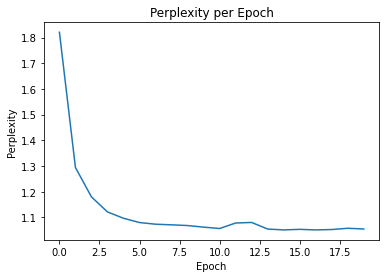

In [111]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

plot_perplexity(dev_perplexities)

## Prediction and Evaluation

Once trained we can use the model to produce a set of translations. 

In [115]:
golden = ["".join(example.trg) for example in devdataset]
print(len(golden))
print(golden[0])

1591
аароновце


**Now we translate the validation set!**

This might take a little bit of time.

Note that `greedy_decode` will cut-off the sentence when it encounters the end-of-sequence symbol, if we provide it the index of that symbol.

In [118]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in validation_iter:
  batch = rebatch2(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi['<bos>'],
    eos_index=TRG.vocab.stoi['<eos>'])
  hypotheses.append(pred)
  alphas.append(attention)

In [119]:
# we will still need to convert the indices to actual words!
hypotheses[0]

array([ 4,  4,  9,  3,  7,  3, 13, 31,  6])

In [120]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses[0]

['а', 'а', 'р', 'о', 'н', 'о', 'в', 'ц', 'е']

In [121]:
guesses = ["".join(x) for x in hypotheses]
print(len(guesses))
print(guesses[0])


1591
аароновце


In [125]:
print(len(golden))
print(len(guesses))

1591
1591


In [ ]:
!pip install python-Levenshtein
from Levenshtein import distance as lev

In [128]:
# the Levenshtein distance 
levsum=0
levsumnorm=0
accsum=0
for i in range (0, len(golden)):
  #evaluate a single tag
  str1 = golden[i]
  str2 = guesses[i]
  levdist = lev(str1, str2)
  acc = 1.0 if levdist==0 else 0
  #print("levdist[",i,"] = ", levdist)
  levsum+=levdist
  levsumnorm+=levdist/len(str1)
  accsum+=acc
  #print("Sum levenstein distance = ", levsum)
levaverage = levsum/len(golden)
levaveragenorm = levsumnorm/len(golden)
accuracy = accsum/len(golden)
print("Accuracy = ", accuracy)
print("Mean Levenshtein distance = ", levaverage)
print("Mean normalized Levenshtein distance = ", levaveragenorm)


Accuracy =  0.9176618478944061
Mean Levenshtein distance =  0.13890634820867379
Mean normalized Levenshtein distance =  0.01840912099120032


The baseline accuracy was determined using the official sigmorphon2016 code (https://github.com/ryancotterell/sigmorphon2016/tree/master/src/baseline) which was downloaded and compiled and run on Ubuntu linux:

Aggregate

Accuracy: 0.897548711502

Mean Levenshtein: 0.170333123821

Mean Normalized Levenshtein: 0.0225829281062


It is seen that the accuracy as well as the Levenshtein accuracy metrics obtained with the method implemented in this notebook are all better than the baseline. 


The accuracy obtained with the method implemented in this notebook  is slightly higher than the task 1 accuracy for the Russian language reported by Kann and Schutze (2016) (https://aclanthology.org/W16-2010.pdf) -- 91.77% vs. 91.46%.